In [1]:
# %matplotlib nbagg
# %matplotlib inline
import sys
import os
import time
from datetime import datetime

sys.path.append("..")
# 自分のpath
os.chdir("/home/nakamura/HAI/main_server/hai")

import pymongo
from PIL import Image
from matplotlib import pylab as plt
from matplotlib.animation import ArtistAnimation
import matplotlib.animation as animation
import numpy as np
from bson.objectid import ObjectId
from sklearn.decomposition import PCA

from _app import app
from database import mongo
from notebooks.utils.utils import visualize, display_latest_image, display_image, print_time, strtime_to_epoch, epoch_to_strtime

In [2]:
app.config['PORT_DB']

20202

In [3]:
prints = mongo.print.find({"user_name": "koki", 'time': {"$gt": 1509675690.059450}, 
                           "$or": [{"text": "play"}, {"text": 'study'}, {'text': 'sleep'}, {'text': 'stop'}]}, sort=[("_id", pymongo.ASCENDING)])
prints = list(prints)

In [4]:
# start = '2017-11-01 16:00:07'
# end = '2017-11-01 18:16:56'
# st = strtime_to_epoch(start)
# et = strtime_to_epoch(end)
st = prints[0]['time'] - 0.1
et = prints[-1]['time'] + 0.1

images0 = mongo.images.find({'time': {"$gt": st, "$lt": et}, "cam_id": "webcam0"}, sort=[("_id", pymongo.ASCENDING)])
images1 = mongo.images.find({'time': {"$gt": st, "$lt": et}, "cam_id": "webcam1"}, sort=[("_id", pymongo.ASCENDING)])

In [5]:
print(images0.count(), images1.count())

414 379


In [6]:
data = []
labels = []
# 高速化する
for im0  in images0:
    try:
        plt.imshow(Image.open(app.config['RAW_IMG_DIR'] + im0['filename']))
    except:
        continue
    
    images1_l = mongo.images.find({'time': {"$gt": im0['time']}, "cam_id": "webcam1"}, sort=[("_id", pymongo.ASCENDING)])
    while True:
        im1_l = images1_l.next()
        try:
            plt.imshow(Image.open(app.config['RAW_IMG_DIR'] + im1_l['filename']))
            break
        except:
            continue
            
    images1_e = mongo.images.find({'time': {"$lt": im0['time']}, "cam_id": "webcam1"}, sort=[("_id", pymongo.DESCENDING)])
    while True:
        im1_e = images1_e.next()
        try:
            plt.imshow(Image.open(app.config['RAW_IMG_DIR'] + im1_e['filename']))
            break
        except:
            continue
            
    if  im1_l['time'] - im0['time'] > im0['time'] - im1_e['time']:
        im1 = im1_e
    else:
        im1 = im1_l
    
    for l in range(len(prints) - 1):
        if prints[l+1]['time'] >= im0['time']:
            labels.append(l)
            break
            
    data.append([im0, im1])

In [7]:
len(data)

363

In [8]:
len(labels)

363

<IPython.core.display.Javascript object>


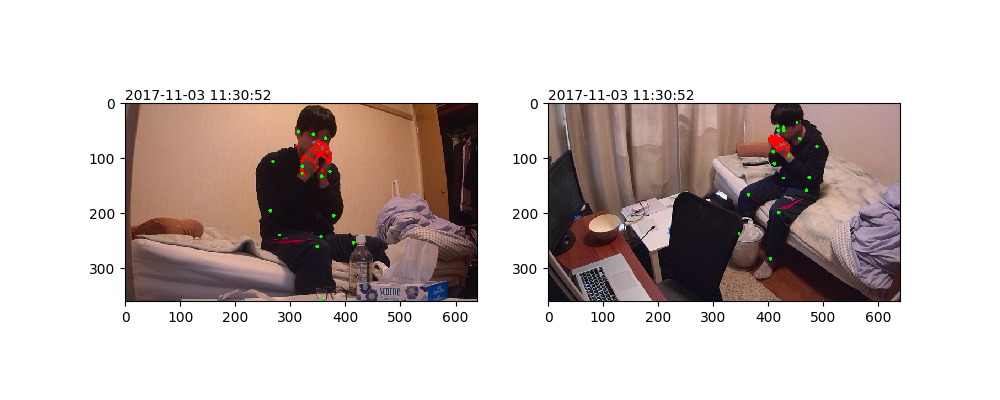

In [8]:
%matplotlib nbagg

num = len(data)
fig, (axL, axR) = plt.subplots(ncols=2, figsize=(10,4))

axL.set_xticklabels([]) 
axR.set_xticklabels([]) 
axL.set_yticklabels([]) 
axR.set_yticklabels([]) 
axL.grid(False)
axR.grid(False)


def update_plot(i):
    axR.clear()
    im0 = data[i][0]
#     im0_path = app.config['RAW_IMG_DIR'] + im0['filename']
#     img0 = Image.open(im0_path, 'r')
#     axR.imshow(img0)
    axR.imshow(visualize(im0))
    axR.text(0, 1.0, epoch_to_strtime(im0['time']),
             horizontalalignment='left',verticalalignment='bottom', transform=axR.transAxes)
    
    axL.clear()
    im1 = data[i][1]
#     im1_path = app.config['RAW_IMG_DIR'] + im1['filename']
#     img1 = Image.open(im1_path, 'r')
#     axL.imshow(img1)
    axL.imshow(visualize(im1))
    axL.text(0, 1.0, epoch_to_strtime(im1['time']),
             horizontalalignment='left',verticalalignment='bottom', transform=axL.transAxes)
    
    return axL, axR


update_plot(0)
ani = animation.FuncAnimation(fig, update_plot, frames=range(num), interval=1000)
# ani.save('data1103.mp4', writer="ffmpeg")
fig.show()

In [18]:
# 0: 勉強
# 1: くつろぎ
# 2: 就寝
# def get_huelabel(t):
#     if t < strtime_to_epoch('2017-11-01 16:05:44'):
#         return 0
#     elif t < strtime_to_epoch('2017-11-01 16:06:44'):
#         return 1
#     elif t < strtime_to_epoch('2017-11-01 16:52:29'):
#         return 2
#     elif t < strtime_to_epoch('2017-11-01 16:57:15'):
#         return 1
#     elif t < strtime_to_epoch('2017-11-01 17:19:15'):
#         return 2
#     elif t < strtime_to_epoch('2017-11-01 17:38:38'):
#         return 1
#     elif t < strtime_to_epoch('2017-11-01 18:10:44'):
#         return 0
#     elif t < strtime_to_epoch('2017-11-01 18:14:12'):
#         return 1
#     else:
#         return 2

In [17]:
X = []
# Y = []
for d in data:
    if ('people' in d[0]['keypoints']) and (len(d[0]['keypoints']['people']) == 1):
        a = np.array(d[0]['keypoints']['people'][0]['pose_keypoints'])
    else:
        a = np.zeros(54)
        
    if ('people' in d[1]['keypoints']) and (len(d[1]['keypoints']['people']) == 1):
        b = np.array(d[1]['keypoints']['people'][0]['pose_keypoints'])
    else:
        b = np.zeros(54)
    
    X.append(np.concatenate((a, b)))
#     Y.append(get_huelabel(d[0]['time']))
        
    

In [19]:
# PCAで2次元に次元削減
pca = PCA(n_components=2)
pca.fit(np.array(X))
X_2d = pca.fit_transform(np.array(X))

In [20]:
X_2d[0]

array([-65.90182308,  30.04466091])

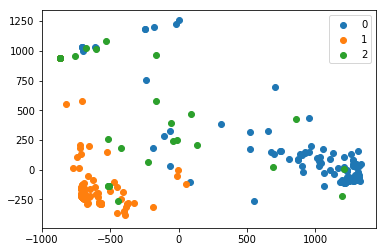

In [21]:
%matplotlib inline
Y = labels
for yl in set(Y):
    indices = [y == yl  for y in Y]
    points = X_2d[indices]
    plt.scatter(points[:, 0], points[:, 1], label=str(yl))
    
plt.legend()
plt.show()

In [22]:
from sklearn.linear_model import LogisticRegression
from sklearn import cross_validation
clf = LogisticRegression()
cross_validation.cross_val_score(clf, X, Y, cv=5)

array([ 0.75675676,  0.93243243,  0.94444444,  0.98611111,  0.88732394])

In [25]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.4, random_state=7)
clf.fit(X_train, y_train)
clf.score(X_test, y_test)

0.93150684931506844

In [29]:
clf.predict(X_test)

array([0, 1, 1, 1, 2, 0, 1, 1, 2, 1, 2, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0,
       1, 0, 0, 1, 1, 0, 0, 2, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 2, 0, 1, 0,
       1, 0, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 2,
       1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 2, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1,
       0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0,
       0, 0, 1, 0, 1, 1, 0, 0, 0, 2, 1, 1, 0, 1, 0, 1, 0, 1, 2, 0, 1, 1, 1,
       1, 1, 0, 1, 1, 0, 1, 0])

In [31]:
np.array(y_test)

array([0, 2, 1, 1, 2, 0, 1, 1, 2, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0,
       1, 0, 0, 1, 1, 0, 0, 2, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0,
       1, 0, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 2, 0, 1, 0, 0,
       1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 2, 0, 2, 1, 1, 0, 0, 1, 1, 1, 1, 1,
       0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 2, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0,
       0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 2, 0, 1, 1, 1,
       1, 1, 0, 1, 1, 0, 1, 0])

In [10]:
from imgaug import augmenters as iaa
def augment_images(img_batch, times):
    images = []
    
    """
    seq = iaa.Sequential([
        iaa.GaussianBlur(sigma=(0, 3.0)), # blur images with a sigma of 0 to 3.0
        iaa.Add((-10, 10), per_channel=0.5), # change brightness of images (by -10 to 10 of original value)
        iaa.AddToHueAndSaturation((-20, 20)),
    ])
    """
    seq = iaa.Sequential([
        # iaa.Fliplr(0.5), # horizontal flips
        iaa.Crop(percent=(0, 0.1)), # random crops
        # Small gaussian blur with random sigma between 0 and 0.5.
        # But we only blur about 50% of all images.
        iaa.Grayscale(alpha=1.0),
        iaa.ContrastNormalization((0.1, 0.9)),
        iaa.Add((-50, 50), True),
#      iaa.GaussianBlur(sigma=(0, 0.5)
        # Strengthen or weaken the contrast in each image.
#         iaa.ContrastNormalization((0.75, 1.5)),
        # Add gaussian noise.
        # For 50% of all images, we sample the noise once per pixel.
        # For the other 50% of all images, we sample the noise per pixel AND
        # channel. This can change the color (not only brightness) of the
        # pixels.
#         iaa.AdditiveGaussianNoise(loc=0, scale=(0.0, 0.05*255), per_channel=0.5),
        # Make some images brighter and some darker.
        # In 20% of all cases, we sample the multiplier once per channel,
        # which can end up changing the color of the images.
#         iaa.Multiply((0.8, 1.2), per_channel=0.2),
        # Apply affine transformations to each image.
        # Scale/zoom them, translate/move them, rotate them and shear them.
#         iaa.Affine(
#             scale={"x": (0.8, 1.2), "y": (0.8, 1.2)},
#             translate_percent={"x": (-0.2, 0.2), "y": (-0.2, 0.2)},
#             rotate=(-25, 25),
#             shear=(-8, 8)
#         )
    ], random_order=True)

    for i in range(times):
        print("{}/{}".format(i, times))
        images_aug = seq.augment_images(img_batch)
        images.extend(images_aug)
        
    return images


0/10
1/10
2/10
3/10
4/10
5/10
6/10
7/10
8/10
9/10


<IPython.core.display.Javascript object>


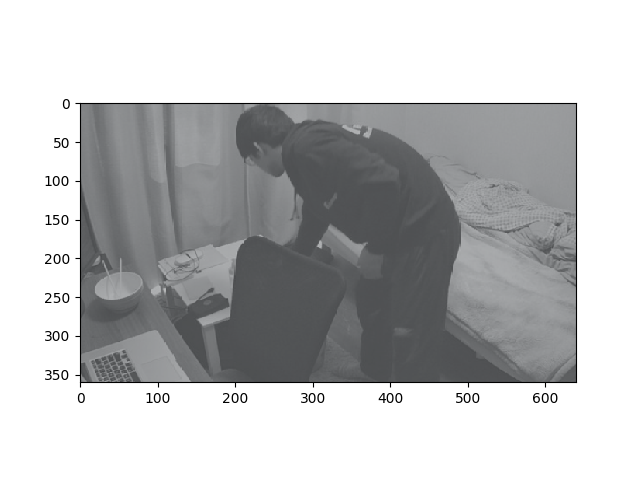

<IPython.core.display.Javascript object>


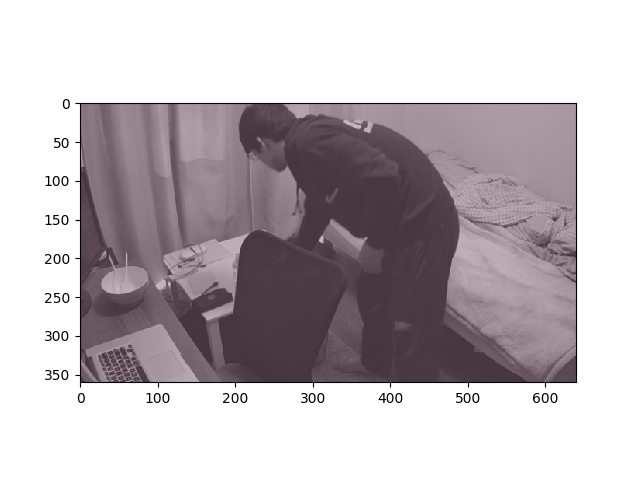

<IPython.core.display.Javascript object>


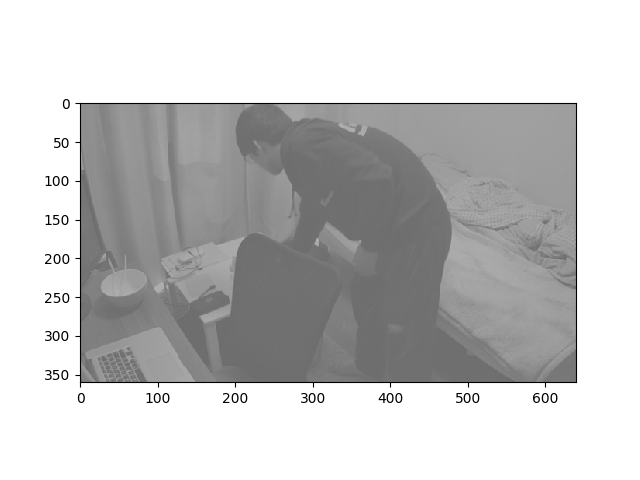

<IPython.core.display.Javascript object>


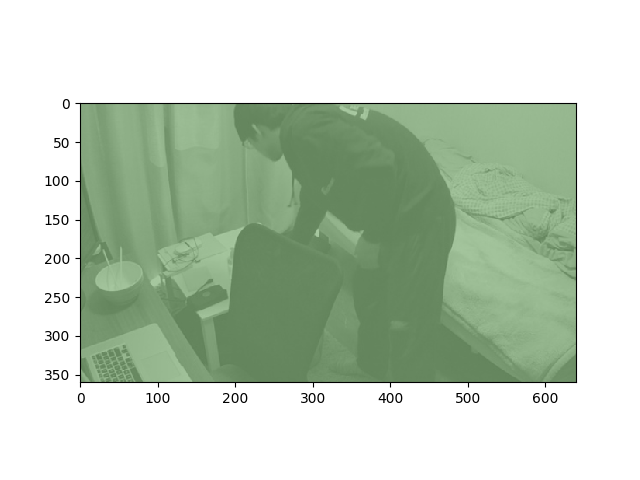

<IPython.core.display.Javascript object>


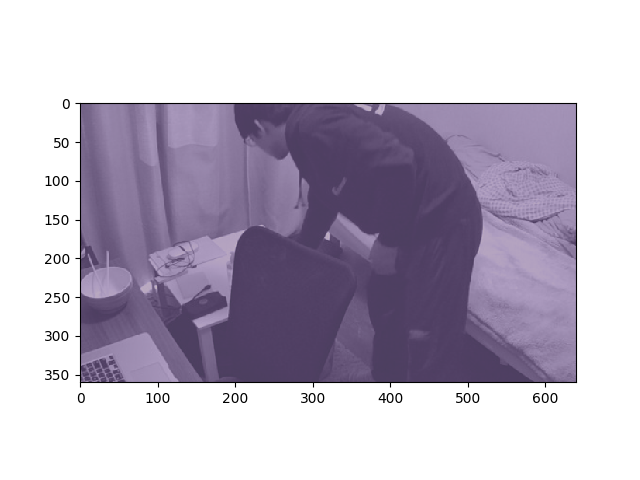

<IPython.core.display.Javascript object>


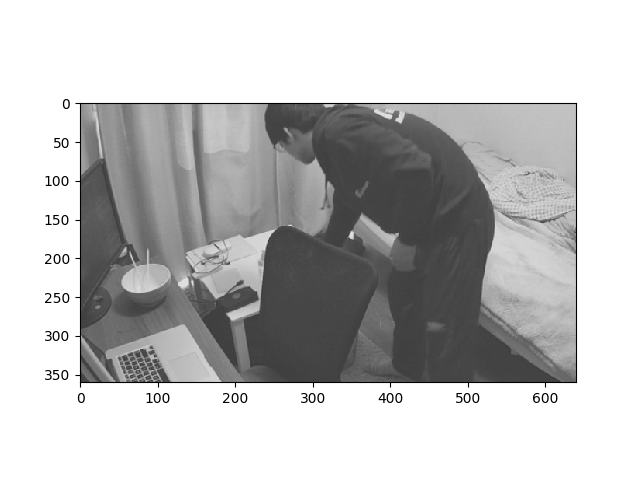

<IPython.core.display.Javascript object>


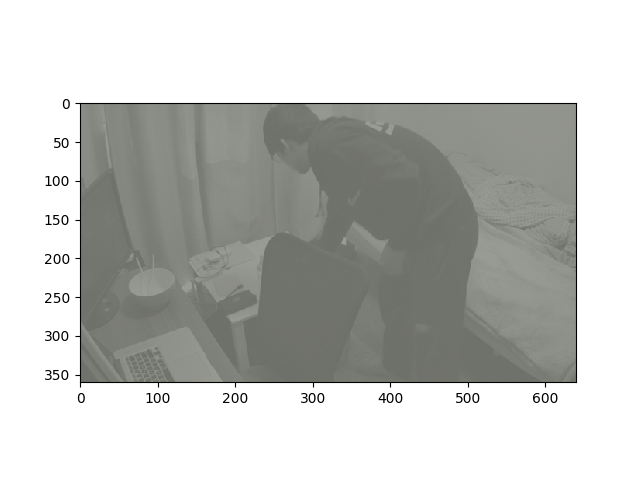

<IPython.core.display.Javascript object>


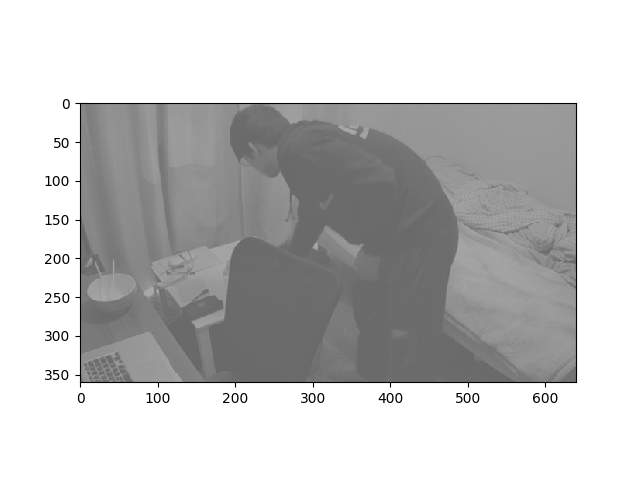

<IPython.core.display.Javascript object>


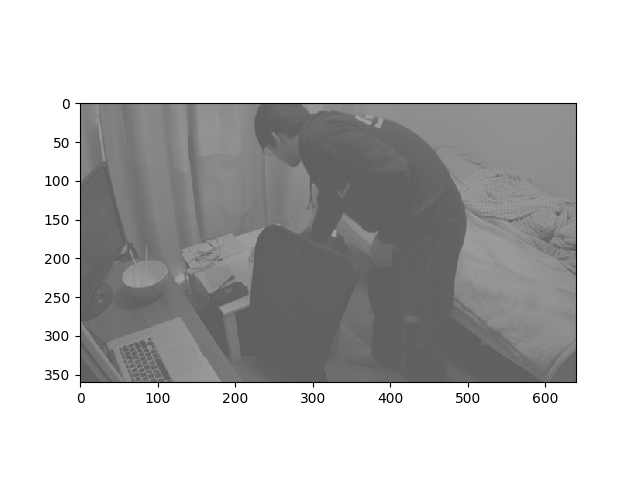

<IPython.core.display.Javascript object>


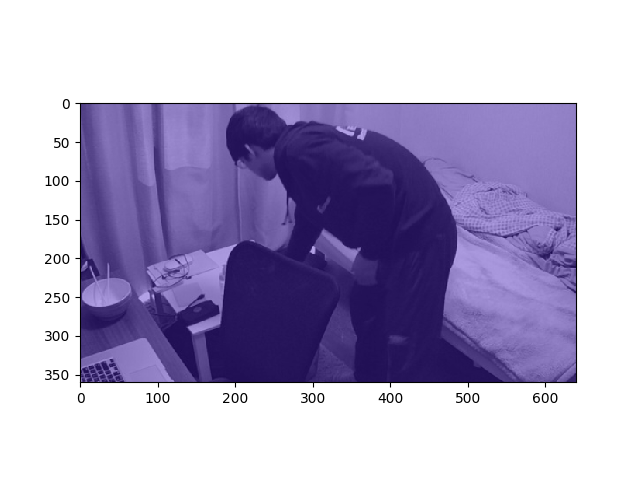

In [11]:
img_batch = [np.array(Image.open(app.config['RAW_IMG_DIR'] + data[0][0]['filename']))]
aug_imgs = augment_images(img_batch, 10)
def show_images(imgs):
    for img in imgs:
        plt.figure()
        plt.imshow(img)
        plt.show()

show_images(aug_imgs)

In [15]:
aug_imgs

[array([[[128, 130, 132],
         [129, 131, 133],
         [130, 132, 134],
         ..., 
         [153, 154, 156],
         [153, 155, 156],
         [153, 155, 156]],
 
        [[128, 130, 131],
         [129, 131, 133],
         [130, 131, 133],
         ..., 
         [152, 154, 156],
         [153, 154, 156],
         [153, 155, 156]],
 
        [[127, 129, 131],
         [128, 130, 131],
         [129, 131, 132],
         ..., 
         [152, 154, 156],
         [152, 154, 156],
         [152, 154, 156]],
 
        ..., 
        [[120, 122, 124],
         [124, 125, 127],
         [134, 135, 137],
         ..., 
         [ 95,  97,  99],
         [ 95,  97,  99],
         [ 95,  97,  99]],
 
        [[116, 118, 120],
         [117, 119, 121],
         [126, 128, 130],
         ..., 
         [ 95,  96,  98],
         [ 94,  95,  97],
         [ 94,  95,  98]],
 
        [[109, 110, 112],
         [117, 119, 121],
         [120, 122, 124],
         ..., 
         [ 93,  95,  97